In [1]:
import numpy as np
import matplotlib.pyplot as plt
import  torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import h5py

In [3]:
all_dataset = h5py.File("/content/drive/MyDrive/projects/chiikawa_classification/data/datasets.hdf5", "r")

X_train = np.array(all_dataset["train_set_X"])
y_train = np.array(all_dataset["train_set_y"])

X_val = np.array(all_dataset["val_set_X"])
y_val = np.array(all_dataset["val_set_y"])

X_test = np.array(all_dataset["test_set_X"])
y_test = np.array(all_dataset["test_set_y"])

In [4]:
print(X_train.shape, X_val.shape, X_test.shape)

(897, 64, 64, 3) (100, 64, 64, 3) (100, 64, 64, 3)


In [5]:
class ImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.Tensor(x).permute(0,3,1,2).float() #NCHW -> NHWC
        self.y = torch.Tensor(y).type(torch.LongTensor)
               
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        image = self.x[index] / 255.0
        target = self.y[index]
        
        return image, target

In [7]:
BATCH_SIZE = 32

train_dataloader = DataLoader(ImageDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(ImageDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(ImageDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [8]:
from torchvision import models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
n_epoch = 10
lr = 2e-4

opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [10]:
def train_model(model, criterion, optimizer, num_epochs=10):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # epochの損失和
            running_corrects = 0 # epochの正解数

            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                #学習フェーズならパラメータ更新
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model

In [11]:
model = train_model(model, criterion, opt, n_epoch)

cuda:0
Epoch 0/9
----------
train Loss: 0.0928 Acc: 0.9666
val Loss: 0.0078 Acc: 0.9900
Epoch 1/9
----------
train Loss: 0.0064 Acc: 0.9989
val Loss: 0.0025 Acc: 1.0000
Epoch 2/9
----------
train Loss: 0.0071 Acc: 0.9967
val Loss: 0.0013 Acc: 1.0000
Epoch 3/9
----------
train Loss: 0.0052 Acc: 0.9967
val Loss: 0.0010 Acc: 1.0000
Epoch 4/9
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.0091 Acc: 0.9900
Epoch 5/9
----------
train Loss: 0.0039 Acc: 0.9989
val Loss: 0.0007 Acc: 1.0000
Epoch 6/9
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0007 Acc: 1.0000
Epoch 7/9
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.0005 Acc: 1.0000
Epoch 8/9
----------
train Loss: 0.0033 Acc: 0.9989
val Loss: 0.0007 Acc: 1.0000
Epoch 9/9
----------
train Loss: 0.0015 Acc: 0.9989
val Loss: 0.0020 Acc: 1.0000


### テストデータへの評価
- 正解率
- recall (再現率)
- ちいかわなのにちいかわと予測できなかった画像表示

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.eval()
model.to(device)

epoch_corrects = 0
predictions = []
targets = []
images = []
for inputs, labels in (test_dataloader):
  images.extend(inputs)
  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.set_grad_enabled(False):
     outputs = model(inputs)
     _, preds = torch.max(outputs, 1)
     predictions.extend(preds.to('cpu').detach().numpy().copy())
     targets.extend(labels.to('cpu').detach().numpy().copy())
     epoch_corrects += torch.sum(preds == labels.data)

epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)
print('Accuracy: {:.4f}'.format(epoch_acc))

cuda:0
Accuracy: 1.0000


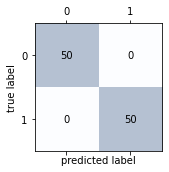

Precision：1.0.
Recall：1.0.


In [13]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=targets, y_pred=predictions)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

precision = precision_score(targets, predictions)
recall = recall_score(targets, predictions)
print(f'Precision：{precision}.')
print(f'Recall：{recall}.')

ちいかわでないと予測したけどちいかわだったやつを抜き取る

In [14]:
targets = np.array(targets)
predictions = np.array(predictions)
images = np.array(images)
idx = np.where( (targets==1) & (predictions==0) )[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

In [15]:
import matplotlib.pyplot as plt

for i in idx:
  print(i)
  plt.imshow(images[i].to('cpu').detach().numpy().transpose(1, 2, 0))
  plt.show()
plt.close()